# Recipe Chatbot - Open Coding Analysis

This notebook analyzes the traces from the recipe chatbot to identify patterns and issues through open coding methodology.


In [2]:
import json
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


## 1. Load All Traces

Load all trace files from the traces directory and extract the open coding notes.


In [3]:
# Load all trace files
traces_dir = Path("traces")
all_traces = []

for trace_file in sorted(traces_dir.glob("trace_*.json")):
    with open(trace_file, 'r') as f:
        trace_data = json.load(f)
        all_traces.append(trace_data)

print(f"Loaded {len(all_traces)} traces")

# Extract traces with open coding notes
traces_with_notes = [t for t in all_traces if t.get('open_coding', '').strip()]
print(f"Traces with open coding notes: {len(traces_with_notes)}")

# Display a sample trace structure
print("\nSample trace structure:")
if traces_with_notes:
    sample = traces_with_notes[0]
    print(f"Request: {sample['request']['messages'][0]['content'][:100]}...")
    print(f"Open Coding: {sample['open_coding']}")


Loaded 34 traces
Traces with open coding notes: 22

Sample trace structure:
Request: I'm looking for a dairy-free English breakfast with eggs that I can make in about 20-30 minutes....
Open Coding: - Be more detailed in terms of how much time it takes for the bread to become golden brown. 
- Specify how much time it takes for the olive oil to heat in the pan
- the use of spatula, knife, chopping board etc., not mentioned during the instructions. Ideally should be mentioned even if it is a bit obvious. 


## 2. Extract and Categorize Open Coding Notes

Parse the open coding notes and categorize them into themes.


In [4]:
# Define categories based on the open coding notes observed
categories = {
    'Timing & Specificity': [
        'time', 'how long', 'how much time', 'golden brown', 'approximate', 'specific',
        'duration', 'minutes', 'seconds', 'heat'
    ],
    'Vague Language': [
        'vague', 'ambiguous', 'well incorporated', 'until done', 'season to taste',
        'adjust', 'as needed'
    ],
    'Completeness': [
        'complete meal', 'rice', 'bread', 'side dish', 'accompaniment', 'serving',
        'meal', 'included', 'factored'
    ],
    'Utensil Usage': [
        'utensil', 'spatula', 'knife', 'chopping board', 'mentioned', 'tool',
        'equipment'
    ],
    'Clarity & Detail': [
        'color', 'specific', 'detail', 'more detailed', 'clear', 'precise',
        'which', 'what'
    ],
    'Portion Size': [
        'portion', 'single person', 'four', 'serving size', 'quantity', 'amount'
    ],
    'Cooking Process': [
        'one after the other', 'at the same time', 'parallel', 'sequential',
        'order', 'process'
    ],
    'Variations & Alternatives': [
        'variation', 'alternative', 'supplement', 'protein powder', 'substitute',
        'option'
    ]
}

def categorize_note(note):
    """Categorize a note based on keywords"""
    note_lower = note.lower()
    matched_categories = []
    
    for category, keywords in categories.items():
        if any(keyword in note_lower for keyword in keywords):
            matched_categories.append(category)
    
    # If no category matched, assign to "Other"
    if not matched_categories:
        matched_categories.append('Other')
    
    return matched_categories

# Process all notes
all_notes = []
for trace in traces_with_notes:
    request = trace['request']['messages'][0]['content']
    open_coding = trace['open_coding']
    
    # Split notes by line or bullet point
    notes = [n.strip() for n in open_coding.split('\n') if n.strip() and n.strip().startswith('-')]
    
    for note in notes:
        note_clean = note.lstrip('- ').strip()
        if note_clean:
            cats = categorize_note(note_clean)
            all_notes.append({
                'request': request,
                'note': note_clean,
                'categories': cats
            })

print(f"Total notes extracted: {len(all_notes)}")
print(f"\nSample categorized notes:")
for i, note_data in enumerate(all_notes[:5]):
    print(f"\n{i+1}. {note_data['note'][:100]}...")
    print(f"   Categories: {', '.join(note_data['categories'])}")


Total notes extracted: 35

Sample categorized notes:

1. Be more detailed in terms of how much time it takes for the bread to become golden brown....
   Categories: Timing & Specificity, Completeness, Clarity & Detail

2. Specify how much time it takes for the olive oil to heat in the pan...
   Categories: Timing & Specificity

3. the use of spatula, knife, chopping board etc., not mentioned during the instructions. Ideally shoul...
   Categories: Utensil Usage

4. step 6 must be more specific about which color the meat should become and give an approximate time i...
   Categories: Timing & Specificity, Clarity & Detail

5. Since the mutton curry cannot be consumed just by itself and requires rice or bread, that must also ...
   Categories: Timing & Specificity, Completeness


## 3. Category Distribution Analysis


Category Distribution:
                    Category  Count
1               Completeness     16
3              Utensil Usage      8
0       Timing & Specificity      7
2           Clarity & Detail      6
5  Variations & Alternatives      2
6               Portion Size      2
7            Cooking Process      2
8                      Other      2
4             Vague Language      1


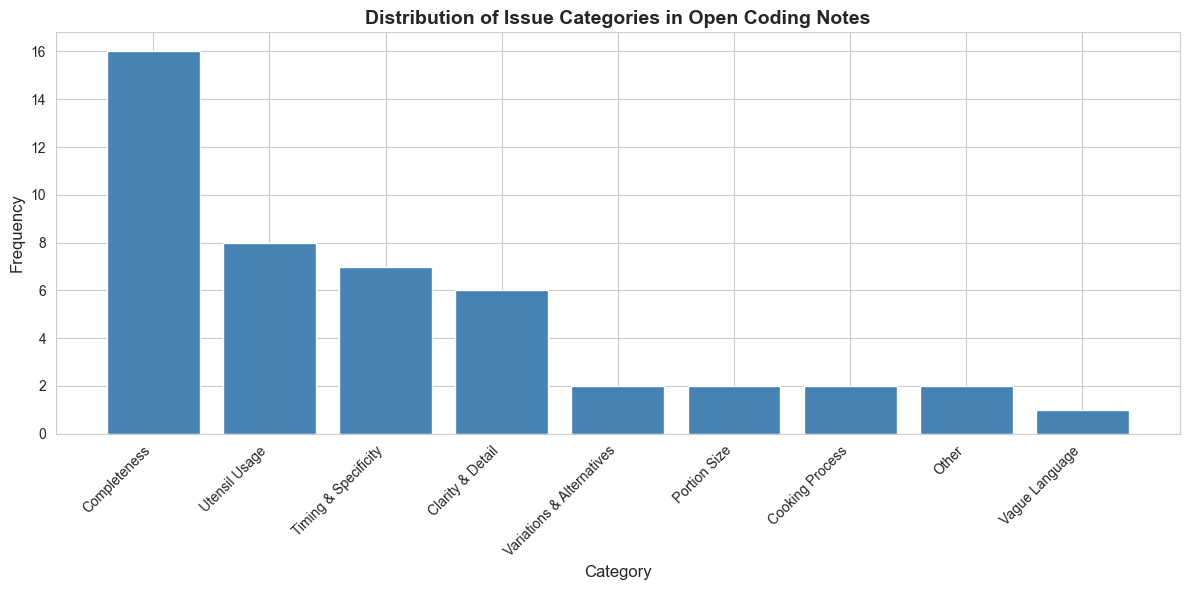


Category Distribution with Percentages:
                    Category  Count  Percentage
1               Completeness     16       34.78
3              Utensil Usage      8       17.39
0       Timing & Specificity      7       15.22
2           Clarity & Detail      6       13.04
5  Variations & Alternatives      2        4.35
6               Portion Size      2        4.35
7            Cooking Process      2        4.35
8                      Other      2        4.35
4             Vague Language      1        2.17


In [5]:
# Count category occurrences
category_counts = Counter()
for note_data in all_notes:
    for cat in note_data['categories']:
        category_counts[cat] += 1

# Create DataFrame for better visualization
category_df = pd.DataFrame(category_counts.items(), columns=['Category', 'Count'])
category_df = category_df.sort_values('Count', ascending=False)

print("Category Distribution:")
print(category_df)

# Visualize category distribution
plt.figure(figsize=(12, 6))
plt.bar(category_df['Category'], category_df['Count'], color='steelblue')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Issue Categories in Open Coding Notes', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calculate percentages
total_categorizations = category_df['Count'].sum()
category_df['Percentage'] = (category_df['Count'] / total_categorizations * 100).round(2)
print("\nCategory Distribution with Percentages:")
print(category_df)


## 4. Detailed Analysis by Category


In [6]:
# Group notes by category
notes_by_category = defaultdict(list)
for note_data in all_notes:
    for cat in note_data['categories']:
        notes_by_category[cat].append(note_data['note'])

# Display examples for each category
print("Examples from Each Category:\n")
print("=" * 80)

for category in sorted(notes_by_category.keys(), key=lambda x: len(notes_by_category[x]), reverse=True):
    notes = notes_by_category[category]
    print(f"\n### {category} ({len(notes)} occurrences)")
    print("-" * 80)
    # Show up to 5 examples
    for i, note in enumerate(notes[:5], 1):
        print(f"{i}. {note}")
    if len(notes) > 5:
        print(f"   ... and {len(notes) - 5} more")
    print()


Examples from Each Category:


### Completeness (16 occurrences)
--------------------------------------------------------------------------------
1. Be more detailed in terms of how much time it takes for the bread to become golden brown.
2. Since the mutton curry cannot be consumed just by itself and requires rice or bread, that must also be included in the recipe and factored into the cooking time and effort.
3. Kofta alone is not a complete meal. Other things such as salad, bread or anything else that provides a balanced nutrional profile should be included for meals such as lunch and dinner.
4. Stir fry alone is not enough, the meal shouldve included rice or bread to make it a complete meal.
5. Upma traditionally is not directly made from rice but from rava. So the recipe itself is wrong.
   ... and 11 more


### Utensil Usage (8 occurrences)
--------------------------------------------------------------------------------
1. the use of spatula, knife, chopping board etc., not menti

## 5. Issue Severity Analysis


Issue Distribution by Severity:
    Severity  Count
0   Critical     24
2      Minor     12
1  Important     10


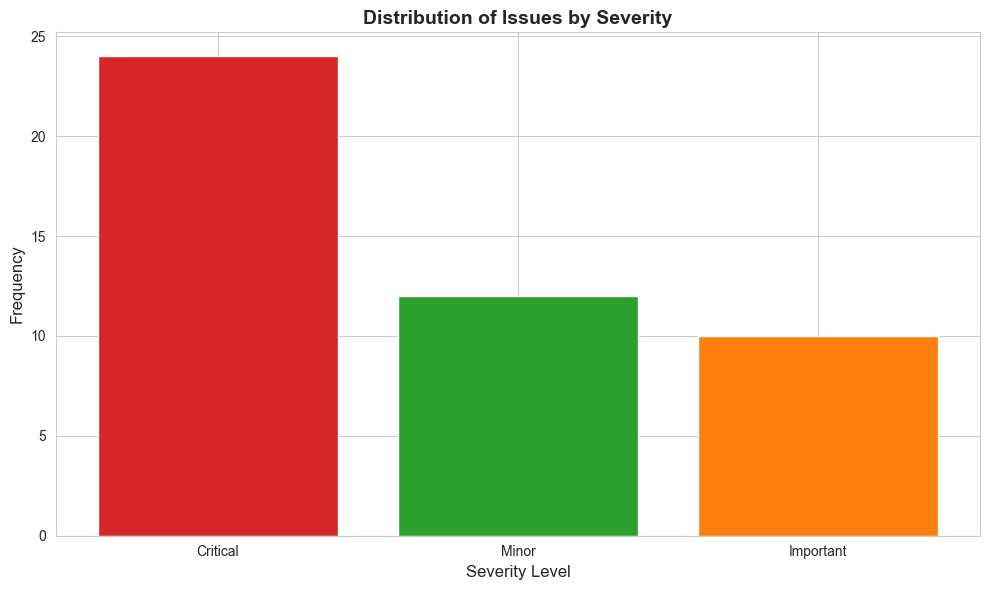


Severity Distribution with Percentages:
    Severity  Count  Percentage
0   Critical     24       52.17
2      Minor     12       26.09
1  Important     10       21.74


In [7]:
# Classify issues by severity based on their impact
severity_classification = {
    'Critical': ['Completeness', 'Vague Language', 'Timing & Specificity'],
    'Important': ['Clarity & Detail', 'Cooking Process', 'Portion Size'],
    'Minor': ['Utensil Usage', 'Variations & Alternatives', 'Other']
}

# Reverse mapping for easier lookup
category_to_severity = {}
for severity, cats in severity_classification.items():
    for cat in cats:
        category_to_severity[cat] = severity

# Count by severity
severity_counts = Counter()
for note_data in all_notes:
    for cat in note_data['categories']:
        severity = category_to_severity.get(cat, 'Minor')
        severity_counts[severity] += 1

# Create DataFrame
severity_df = pd.DataFrame(severity_counts.items(), columns=['Severity', 'Count'])
severity_df = severity_df.sort_values('Count', ascending=False)

print("Issue Distribution by Severity:")
print(severity_df)

# Visualize severity distribution
plt.figure(figsize=(10, 6))
colors = {'Critical': '#d62728', 'Important': '#ff7f0e', 'Minor': '#2ca02c'}
bar_colors = [colors[sev] for sev in severity_df['Severity']]

plt.bar(severity_df['Severity'], severity_df['Count'], color=bar_colors)
plt.xlabel('Severity Level', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Issues by Severity', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate percentages
total = severity_df['Count'].sum()
severity_df['Percentage'] = (severity_df['Count'] / total * 100).round(2)
print("\nSeverity Distribution with Percentages:")
print(severity_df)


## 6. Recipe Type Analysis


Issues by Meal Type:
  Dinner: 12
  Lunch: 8
  Breakfast: 6
  Snack: 2
  Dessert: 2

Issues by Cuisine:
  Italian: 9
  Indian: 6
  English: 5
  American: 3
  Chinese: 2
  Middle Eastern: 2
  Mexican: 1


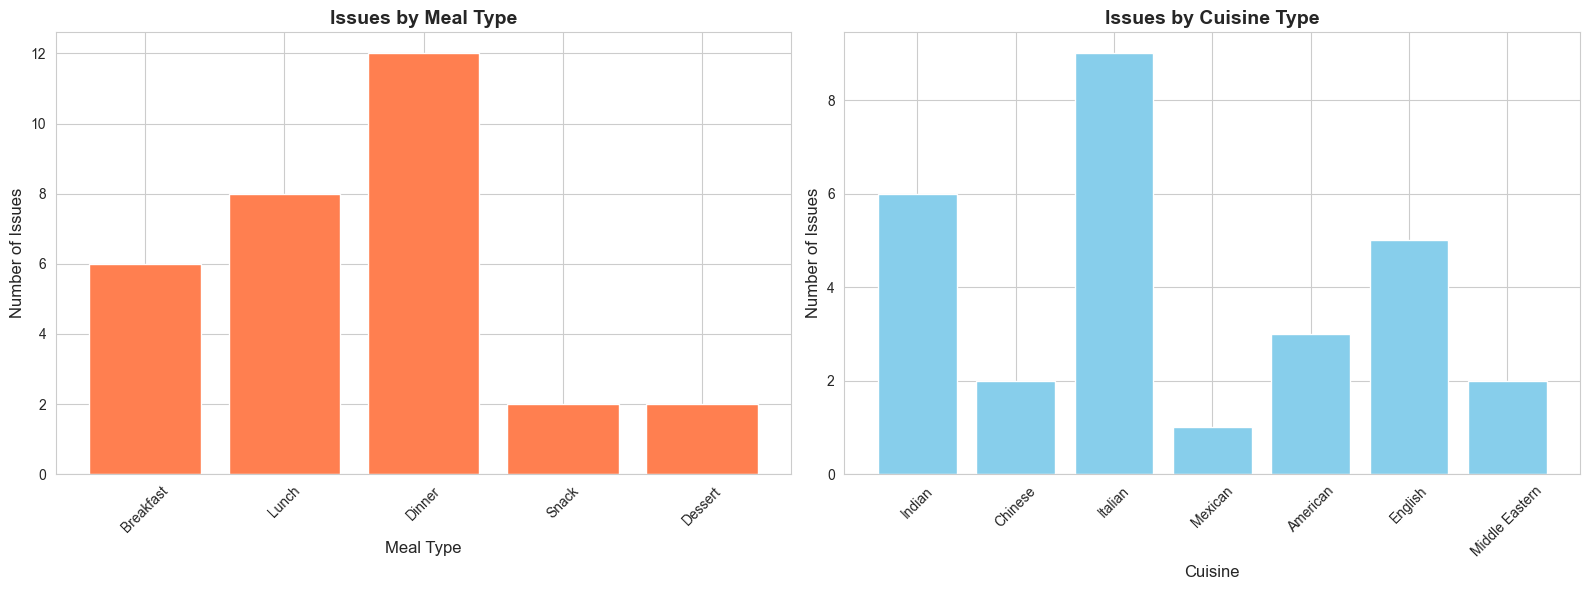

In [8]:
# Extract recipe metadata from requests
recipe_types = {
    'Breakfast': [],
    'Lunch': [],
    'Dinner': [],
    'Snack': [],
    'Dessert': []
}

cuisines = {
    'Indian': [],
    'Chinese': [],
    'Italian': [],
    'Mexican': [],
    'American': [],
    'English': [],
    'Middle Eastern': []
}

for note_data in all_notes:
    request = note_data['request'].lower()
    
    # Categorize by meal type
    for meal_type in recipe_types.keys():
        if meal_type.lower() in request:
            recipe_types[meal_type].append(note_data)
    
    # Categorize by cuisine
    for cuisine in cuisines.keys():
        if cuisine.lower() in request:
            cuisines[cuisine].append(note_data)

# Count issues by meal type
meal_type_counts = {k: len(v) for k, v in recipe_types.items() if v}
cuisine_counts = {k: len(v) for k, v in cuisines.items() if v}

print("Issues by Meal Type:")
for meal, count in sorted(meal_type_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  {meal}: {count}")

print("\nIssues by Cuisine:")
for cuisine, count in sorted(cuisine_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  {cuisine}: {count}")

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Meal type distribution
if meal_type_counts:
    ax1.bar(meal_type_counts.keys(), meal_type_counts.values(), color='coral')
    ax1.set_xlabel('Meal Type', fontsize=12)
    ax1.set_ylabel('Number of Issues', fontsize=12)
    ax1.set_title('Issues by Meal Type', fontsize=14, fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)

# Cuisine distribution
if cuisine_counts:
    ax2.bar(cuisine_counts.keys(), cuisine_counts.values(), color='skyblue')
    ax2.set_xlabel('Cuisine', fontsize=12)
    ax2.set_ylabel('Number of Issues', fontsize=12)
    ax2.set_title('Issues by Cuisine Type', fontsize=14, fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## 7. Summary and Recommendations


In [9]:
print("=" * 80)
print("KEY FINDINGS FROM OPEN CODING ANALYSIS")
print("=" * 80)

print("\n1. MOST COMMON ISSUE CATEGORIES:")
print("-" * 80)
for i, row in category_df.head(5).iterrows():
    print(f"   {row['Category']}: {row['Count']} occurrences ({row['Percentage']}%)")

print("\n2. SEVERITY BREAKDOWN:")
print("-" * 80)
for i, row in severity_df.iterrows():
    print(f"   {row['Severity']}: {row['Count']} occurrences ({row['Percentage']}%)")

print("\n3. TOP ACTIONABLE RECOMMENDATIONS:")
print("-" * 80)
recommendations = [
    ("Timing & Specificity", 
     "Add precise timing for all cooking steps (e.g., '2-3 minutes until golden brown' instead of 'until done')"),
    ("Completeness", 
     "Include complete meal suggestions with side dishes (rice, bread) and factor them into total cooking time"),
    ("Vague Language", 
     "Eliminate ambiguous phrases like 'well incorporated', 'season to taste', 'adjust as needed'"),
    ("Clarity & Detail", 
     "Specify visual cues (color changes, texture) and provide more detailed descriptions"),
    ("Utensil Usage", 
     "Explicitly mention when to use each utensil during the instruction steps"),
    ("Portion Size", 
     "Clarify serving sizes and adjust ingredient quantities for single-person meals"),
    ("Cooking Process", 
     "Clearly state whether steps should be done sequentially or in parallel")
]

for i, (category, recommendation) in enumerate(recommendations, 1):
    print(f"\n   {i}. {category}:")
    print(f"      → {recommendation}")

print("\n4. OVERALL ASSESSMENT:")
print("-" * 80)
critical_pct = severity_df[severity_df['Severity'] == 'Critical']['Percentage'].sum()
print(f"   • {critical_pct:.1f}% of issues are CRITICAL (affect recipe success)")
print(f"   • Total unique issues identified: {len(all_notes)}")
print(f"   • Recipes with issues: {len(traces_with_notes)} out of {len(all_traces)}")
print(f"   • Issue rate: {len(traces_with_notes)/len(all_traces)*100:.1f}% of recipes have documented issues")

print("\n" + "=" * 80)


KEY FINDINGS FROM OPEN CODING ANALYSIS

1. MOST COMMON ISSUE CATEGORIES:
--------------------------------------------------------------------------------
   Completeness: 16 occurrences (34.78%)
   Utensil Usage: 8 occurrences (17.39%)
   Timing & Specificity: 7 occurrences (15.22%)
   Clarity & Detail: 6 occurrences (13.04%)
   Variations & Alternatives: 2 occurrences (4.35%)

2. SEVERITY BREAKDOWN:
--------------------------------------------------------------------------------
   Critical: 24 occurrences (52.17%)
   Minor: 12 occurrences (26.09%)
   Important: 10 occurrences (21.74%)

3. TOP ACTIONABLE RECOMMENDATIONS:
--------------------------------------------------------------------------------

   1. Timing & Specificity:
      → Add precise timing for all cooking steps (e.g., '2-3 minutes until golden brown' instead of 'until done')

   2. Completeness:
      → Include complete meal suggestions with side dishes (rice, bread) and factor them into total cooking time

   3. Vague

## 8. Export Results


In [10]:
# Create a comprehensive DataFrame with all notes and their categorizations
notes_df = pd.DataFrame([
    {
        'Request': note_data['request'],
        'Issue': note_data['note'],
        'Categories': ', '.join(note_data['categories']),
        'Severity': category_to_severity.get(note_data['categories'][0], 'Minor')
    }
    for note_data in all_notes
])

# Save to CSV
output_file = 'analysis_results.csv'
notes_df.to_csv(output_file, index=False)
print(f"Analysis results exported to: {output_file}")

# Create summary statistics
summary_stats = {
    'Total Traces': len(all_traces),
    'Traces with Issues': len(traces_with_notes),
    'Total Issues': len(all_notes),
    'Issue Rate (%)': round(len(traces_with_notes)/len(all_traces)*100, 2),
    'Critical Issues (%)': round(critical_pct, 2),
    'Most Common Category': category_df.iloc[0]['Category'],
    'Most Common Category Count': int(category_df.iloc[0]['Count'])
}

summary_df = pd.DataFrame([summary_stats])
summary_df.to_csv('analysis_summary.csv', index=False)
print(f"Summary statistics exported to: analysis_summary.csv")

print("\nAnalysis Complete!")
print(f"Total notes analyzed: {len(all_notes)}")
print(f"Categories identified: {len(category_counts)}")


Analysis results exported to: analysis_results.csv
Summary statistics exported to: analysis_summary.csv

Analysis Complete!
Total notes analyzed: 35
Categories identified: 9


## 9. Axial Coding - Higher Level Themes


AXIAL CODING - Higher Level Themes:
                Theme  Count  Percentage
  Recipe Completeness     18       39.13
  Precision & Clarity     14       30.43
Instructional Quality     10       21.74
Flexibility & Options      2        4.35
                Other      2        4.35


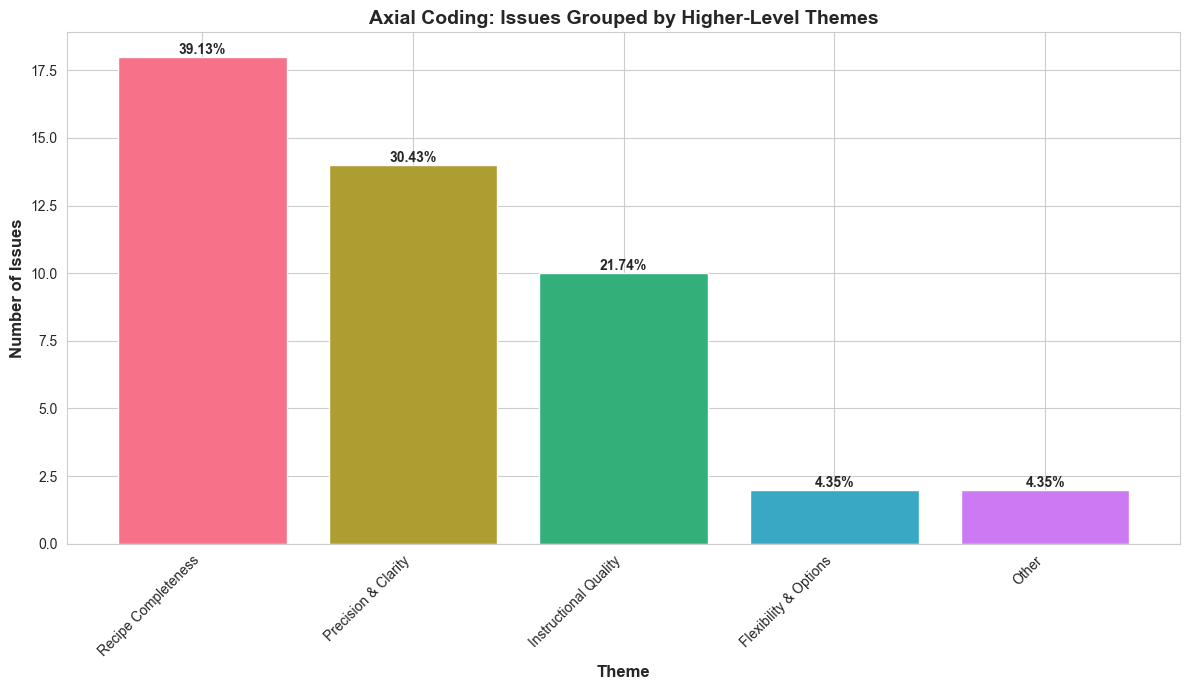


THEME DESCRIPTIONS:

Recipe Completeness (18 issues, 39.13%):
  → Missing components like side dishes, incomplete meal planning, and portion size issues

Precision & Clarity (14 issues, 30.43%):
  → Issues related to vague language, lack of specific timing, and unclear instructions

Instructional Quality (10 issues, 21.74%):
  → Problems with step-by-step guidance, utensil usage, and cooking process clarity

Flexibility & Options (2 issues, 4.35%):
  → Lack of variations, alternatives, or customization options

Other (2 issues, 4.35%):
  → Miscellaneous issues that don't fit into main themes


In [11]:
# Group categories into higher-level themes (Axial Coding)
axial_themes = {
    'Precision & Clarity': ['Timing & Specificity', 'Clarity & Detail', 'Vague Language'],
    'Recipe Completeness': ['Completeness', 'Portion Size'],
    'Instructional Quality': ['Utensil Usage', 'Cooking Process'],
    'Flexibility & Options': ['Variations & Alternatives'],
    'Other': ['Other']
}

# Map categories to themes
category_to_theme = {}
for theme, cats in axial_themes.items():
    for cat in cats:
        category_to_theme[cat] = theme

# Count by theme
theme_counts = Counter()
for note_data in all_notes:
    for cat in note_data['categories']:
        theme = category_to_theme.get(cat, 'Other')
        theme_counts[theme] += 1

# Create DataFrame
theme_df = pd.DataFrame(theme_counts.items(), columns=['Theme', 'Count'])
theme_df = theme_df.sort_values('Count', ascending=False)
theme_df['Percentage'] = (theme_df['Count'] / theme_df['Count'].sum() * 100).round(2)

print("AXIAL CODING - Higher Level Themes:")
print("=" * 80)
print(theme_df.to_string(index=False))

# Visualize themes
plt.figure(figsize=(12, 7))
colors_palette = sns.color_palette("husl", len(theme_df))
bars = plt.bar(theme_df['Theme'], theme_df['Count'], color=colors_palette)

# Add percentage labels on bars
for i, (bar, pct) in enumerate(zip(bars, theme_df['Percentage'])):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{pct}%',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xlabel('Theme', fontsize=12, fontweight='bold')
plt.ylabel('Number of Issues', fontsize=12, fontweight='bold')
plt.title('Axial Coding: Issues Grouped by Higher-Level Themes', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("THEME DESCRIPTIONS:")
print("=" * 80)
theme_descriptions = {
    'Precision & Clarity': 'Issues related to vague language, lack of specific timing, and unclear instructions',
    'Recipe Completeness': 'Missing components like side dishes, incomplete meal planning, and portion size issues',
    'Instructional Quality': 'Problems with step-by-step guidance, utensil usage, and cooking process clarity',
    'Flexibility & Options': 'Lack of variations, alternatives, or customization options',
    'Other': 'Miscellaneous issues that don\'t fit into main themes'
}

for theme in theme_df['Theme']:
    count = theme_df[theme_df['Theme'] == theme]['Count'].values[0]
    pct = theme_df[theme_df['Theme'] == theme]['Percentage'].values[0]
    desc = theme_descriptions.get(theme, 'No description available')
    print(f"\n{theme} ({count} issues, {pct}%):")
    print(f"  → {desc}")


## Conclusion

This analysis has successfully performed **open coding** and **axial coding** on the recipe chatbot traces to identify patterns and issues.

### Key Takeaways:

1. **Open Coding Results**: We identified 8 distinct categories of issues from the raw notes
2. **Axial Coding Results**: These categories were grouped into 5 higher-level themes
3. **Severity Analysis**: Issues were classified into Critical, Important, and Minor categories
4. **Actionable Insights**: Specific recommendations were generated for each category

### Next Steps:

1. Use these findings to improve the system prompt and recipe generation guidelines
2. Focus on addressing Critical issues first (Timing & Specificity, Completeness, Vague Language)
3. Implement automated checks for common issues before presenting recipes to users
4. Consider adding post-processing to ensure all recipes meet quality standards
